In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
np.seterr(all='ignore')
from __future__ import division
%matplotlib inline

In [2]:
# openAI gym-style environment for the merton model

# annual calibration
mu = 0.09
sigma = 0.16
rf = 0.01
period = 1/12
T = 60 # 5 year horizon

def reset():
    state = 1,0 # wealth, time
    done = False
    return state, done
    
def step(state,a):
    w,t = state
    ret = iid_return()
    w *= a * ret + (1-a)*(1 + rf*period)
    t += 1
    done = (t==T)
    if done: # consume and reset
        reward = np.log(w)
        state,_ = reset()
    else: 
        state = w,t
        reward = 0
    return state, reward, done, {'stock return' : ret}
    
def iid_return():
    # distribution of log returns
    mean = (mu - (sigma**2)/2)*period
    std = sigma*np.sqrt(period)
    
    # sample log return
    logret = mean + std * np.random.randn()
    
    return np.exp(logret)

In [3]:
merton = (mu - rf) / (sigma**2) 
print (merton)

3.125


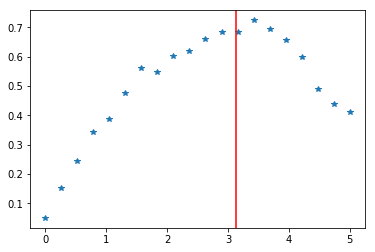

In [4]:
# find the best myopic policy in this world via brute force monte carlo
np.random.seed(213)
A = np.linspace(0,5,20)
av_rewards = []
n_ep = 1000
for a in tqdm_notebook(A):
    V = 0
    for ep in range(n_ep):
        state, done = reset()
        while not done:
            state,reward,done,info = step(state,a)
            V += reward
    V /= n_ep
    av_rewards.append(V)
plt.plot(A,av_rewards,'*')
plt.axvline(merton,color='r')

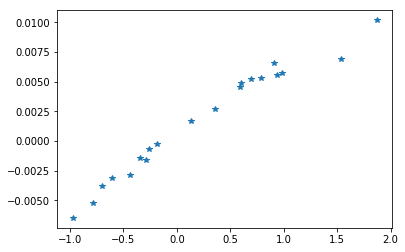

In [5]:
# now we want to write an RL that can do the same but scales to more state variables

# approximate value function
def q(a,w):
    return np.dot(w,x(a))

def x(a):
    return np.array([1,a,a**2])

# initialize
w = 0

# start with some baseline action
mu_a = 0

# take some monte carlo experience of action values around current a
def mc_experience(mu_a,plot=False,n_actions = 20, n_eps = 100):
    np.random.seed(213)
    # exploratory actions
    A = mu_a + 1 * np.random.randn(n_actions)

    # play some episodes for each action and record gains
    G = []
    for a in A:
        rewards = []
        for ep in range(n_eps):
            state, done = reset()
            while not done:
                state,reward,done,info = step(state,a)
                if not np.isnan(reward):
                    rewards.append(reward)
        G.append(np.mean(rewards))
    return A,G

# get experience and visualize
A,G = mc_experience(mu_a,plot=True)
plt.plot(A,G,'*')

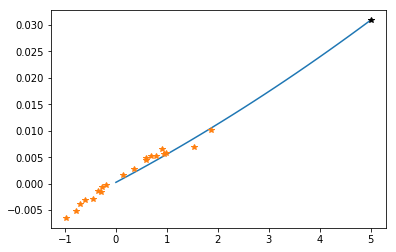

In [6]:
def evaluate(w,A,G,learning_rate = 1e-4,n_steps=2500):
    # do some gradient descent based on "training data"
    for j in range(n_steps):
        gradient = np.vstack([(G[i] - q(A[i],w))*x(A[i]) for i in range(len(A))])
        w  = w + learning_rate * np.sum(gradient,axis=0)
    return w
        
def greedy(w,a_min =0,a_max=5):
    if w[2]>0: # convex case
        a = a_min if w[1]<0 else a_max
    else:
        a = -w[1]/(2*w[2])
    return np.clip(a,a_min,a_max)
    A_space = np.linspace(0,5,25)
    imax = np.argmax([q(a) for a in A_space])
    return A_space[imax]

# one round of learning
w=0
mu_a = 0
A,G = mc_experience(mu_a)
w = evaluate(w,A,G)
mu_a = greedy(w)

# visualization
def visualize_learning(w,A,G):
    plt.figure()
    a_grid = np.linspace(0,5,25)
    plt.plot(a_grid,[q(a,w) for a in a_grid])
    plt.plot(A,G,'*')
    plt.plot(mu_a,q(mu_a,w),'k*')
    return None
visualize_learning(w,A,G)

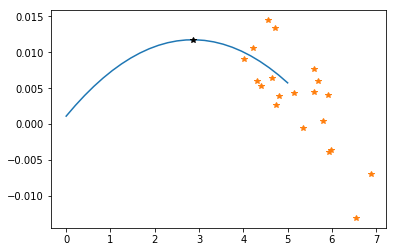

In [7]:
# go again
A,G = mc_experience(mu_a,plot=True)
w = evaluate(w,A,G)
mu_a = greedy(w)
visualize_learning(w,A,G)

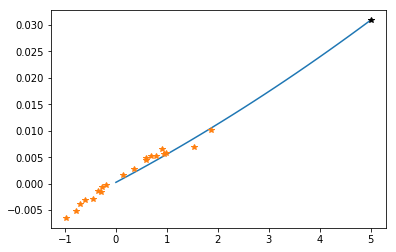

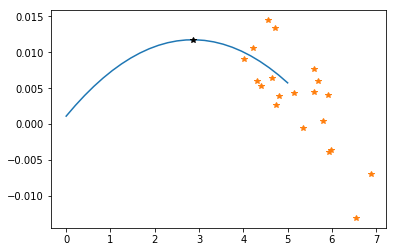

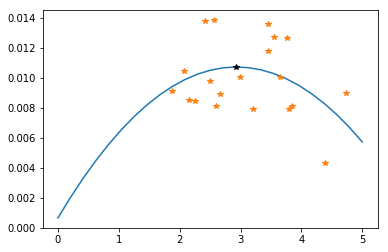

In [8]:
# three rounds in in one
w=0
mu_a = 0
for _ in range(3):
    A,G = mc_experience(mu_a)
    w = evaluate(w,A,G)
    mu_a = greedy(w)
    visualize_learning(w,A,G)

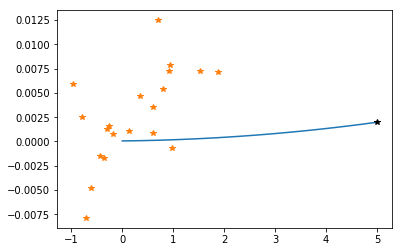

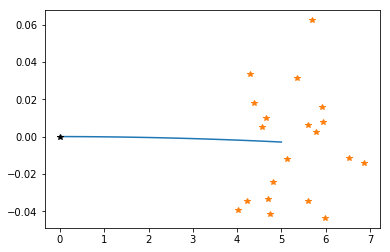

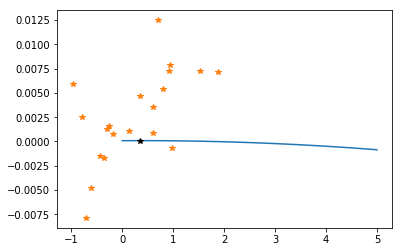

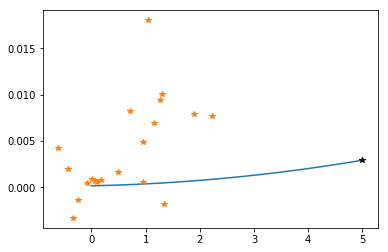

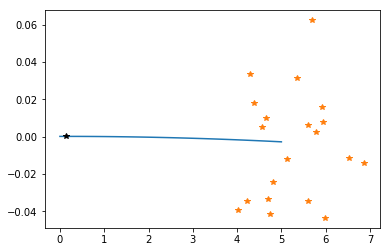

In [9]:
# can we be more efficient?
w=0
mu_a = 0
for _ in range(5):
    A,G = mc_experience(mu_a,n_actions = 20,n_eps=1)
    w = evaluate(w,A,G,n_steps = 10,learning_rate = 1e-4)
    mu_a = greedy(w)
    visualize_learning(w,A,G)